In [106]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from numpy import inf
from scipy.stats import moment

target_rank = 'all players'
df_raw = pd.read_csv('all_player.csv', index_col=0)

# add ratio features
winRate = df_raw['total_wins']/df_raw['total_rounds_played']
winRate[winRate == inf] = 0
KD = df_raw['total_kills']/df_raw['total_deaths']
KD[KD == inf] = 0
HDK = df_raw['total_kills_headshot']/df_raw['total_kills']
HDK[HDK == inf] = 0

df = pd.DataFrame(np.stack([winRate, KD, HDK], axis = 1), index=df_raw.index, columns=['win-rate', 'kill-death', 'headshot-kill'])
df = pd.concat([df, df_raw],axis = 1)
df.shape

(75911, 14)

In [107]:
df_clean = df[ (df['win-rate']<=1) & ( df['headshot-kill']<=1) & (df['total_shots_fired']>df['total_kills']) &\
              (df['total_time_played'] <= 1963*12*60*60)]

df.shape, df_clean.shape

((75911, 14), (74770, 14))

# Correlation

## pearson

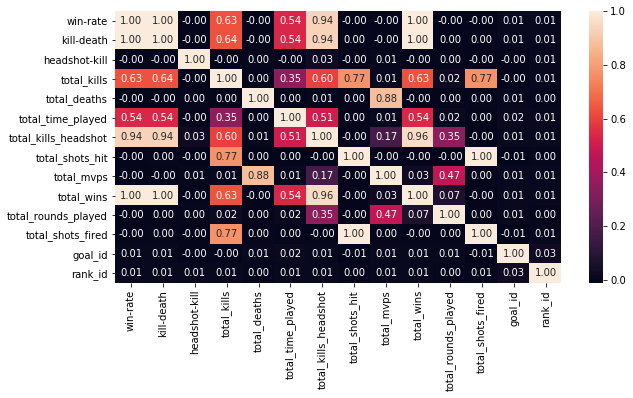

In [101]:
df_corr = df.corr('pearson')

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")
plt.savefig('{}_pearson.png'.format(target_rank))
plt.show()

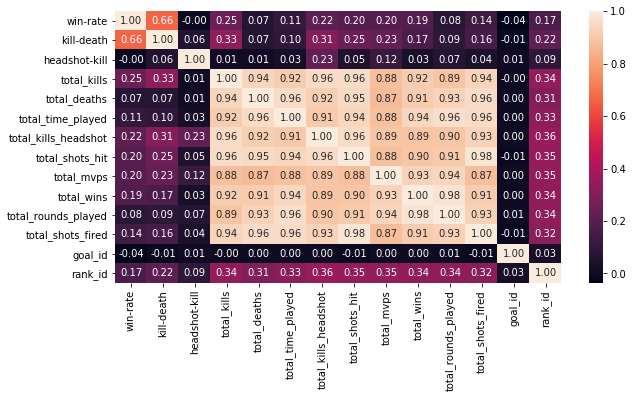

In [102]:
df_corr = df.corr('spearman')

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")
plt.savefig('{}_spearman.png'.format(target_rank))
plt.show()

# K-means

In [108]:
def df_clustering( n_clusters_, colors, df, plot = True):
    kmeans = KMeans(n_clusters=n_clusters_).fit(df[['win-rate', 'kill-death', 'headshot-kill']])
    labels = kmeans.labels_

    c_list = [colors[labels[i]] for i in range(df.shape[0])]

    center = kmeans.cluster_centers_

    x,y,z = df['win-rate'].values,df['kill-death'].values,df['headshot-kill'].values
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 2]

    if plot:
        plt.figure(figsize=(9, 6))
        ax1 = plt.subplot(111,projection='3d')
        
        ax1.scatter(x, y, z, s=15, color=c_list, alpha=0.5)
        ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
        ax1.set_title('Raw Data of rank=18 players Built by KMeans')
        ax1.set_xlabel('win-rate')
        ax1.set_ylabel('kill/death')
        ax1.set_zlabel('headshot/kill')
    
    return [labels, x_c,y_c,z_c]

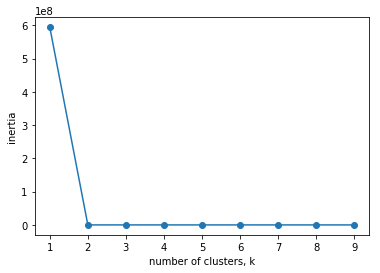

In [109]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_clean[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [113]:
def plot_n_cluster(n_clusters, df):
    plt.figure(figsize=(20, 5))

    ax2 = plt.subplot(121,projection='3d')

    c = df
    x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
    ax2.scatter(x, y, z, s=15, alpha=0.5)

    ax2.set_xlabel('win-rate')
    ax2.set_ylabel('kill/death')
    ax2.set_zlabel('headshot/kill')


    colors = ['orange','green','cyan','red','blue','pink','gray','brown']
    df_labeled, x_c, y_c, z_c = df_clustering(n_clusters, colors, df, plot = False)

    df['label'] = df_labeled


    ax1 = plt.subplot(122,projection='3d')

    for i in range(n_clusters):
        c = df[df.label == i]
        x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
        ax1.scatter(x, y, z, s=15, color=colors[i], alpha=0.5, label='cluster:{}'.format(i))

    ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
    # ax1.set_title('{} clustered by k-means'.format(target_rank))
    ax1.set_xlabel('win-rate')
    ax1.set_ylabel('kill/death')
    ax1.set_zlabel('headshot/kill')
    plt.legend()

    plt.suptitle('{} clustering by k-means'.format(target_rank), fontsize = 20)

    plt.savefig('{} clustering by k-means'.format(target_rank))
    
    return df_labeled, x_c, y_c, z_c
    

# plot_n_cluster(2, df_clean)

In [ ]:
# analyze outlier and 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster size distribution of all players
cluster:	size:	
0		74769
1		1
2		0


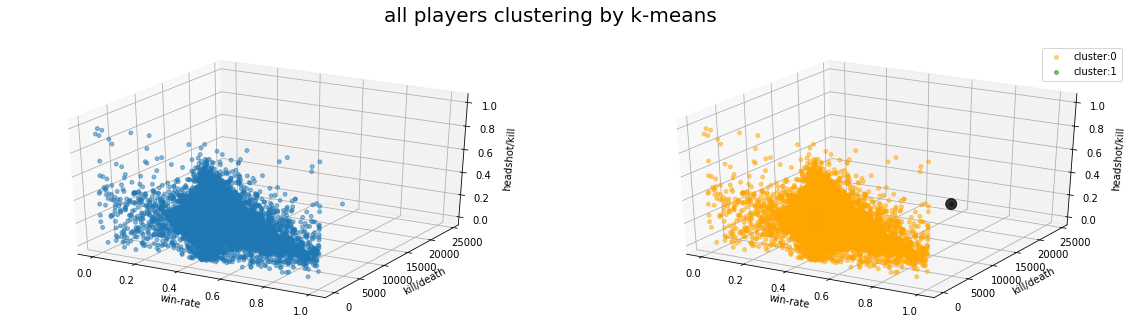

In [112]:
df_labeled, x_c, y_c, z_c = plot_n_cluster(2, df_clean)
# size of each cluster
print('cluster size distribution of {}'.format(target_rank))
count_label0 = list(df_labeled).count(0)
count_label1 = list(df_labeled).count(1)
count_label2 = list(df_labeled).count(2)

print('cluster:\tsize:\t')
print('{}\t\t{}'.format(0, count_label0))
print('{}\t\t{}'.format(1, count_label1))
print('{}\t\t{}'.format(2, count_label2))

In [114]:
# analyze outlier and 
df_drop = df_clean.drop(df_clean.index[list(df_labeled).index(1)])
print(df_drop.shape, df_clean.shape)

(74769, 15) (74770, 15)


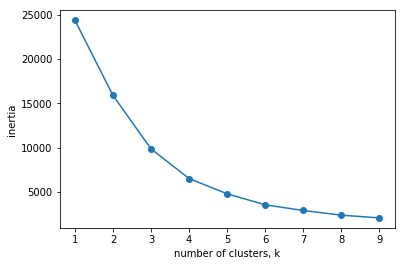

In [115]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_drop[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

cluster size distribution of all players
cluster:	size:	
0		34676
1		1
2		21


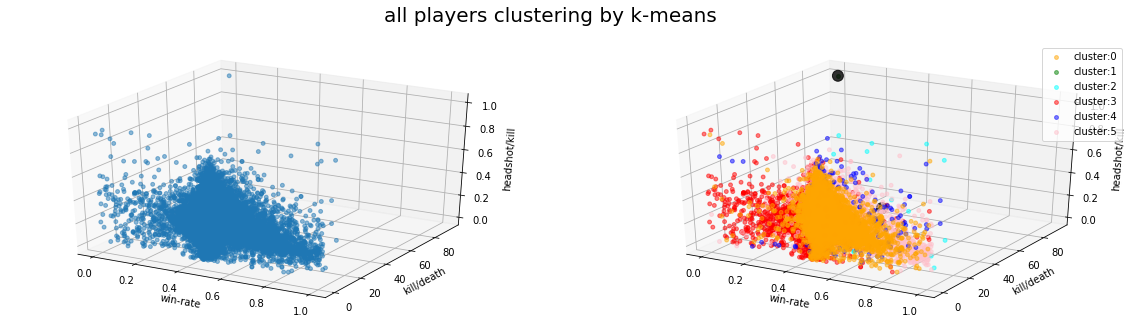

In [116]:
df_labeled, x_c, y_c, z_c = plot_n_cluster(6, df_drop)
# size of each cluster
print('cluster size distribution of {}'.format(target_rank))


In [117]:
count_label0 = list(df_labeled).count(0)
count_label1 = list(df_labeled).count(1)
count_label2 = list(df_labeled).count(2)
count_label3 = list(df_labeled).count(3)
count_label4 = list(df_labeled).count(4)
count_label5 = list(df_labeled).count(5)


print('cluster:\tsize:\t')
print('{}\t\t{}'.format(0, count_label0))
print('{}\t\t{}'.format(1, count_label1))
print('{}\t\t{}'.format(2, count_label2))
print('{}\t\t{}'.format(3, count_label3))
print('{}\t\t{}'.format(4, count_label4))
print('{}\t\t{}'.format(5, count_label5))

cluster:	size:	
0		34676
1		1
2		21
3		36352
4		153
5		3566


(74769, 15) (74770, 15)


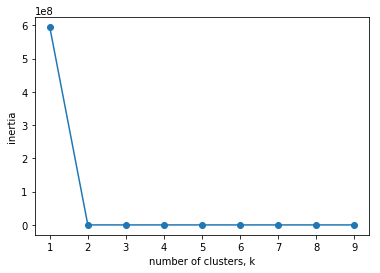

In [119]:
# analyze outlier and 
df_drop = df_clean.drop(df_clean.index[list(df_labeled).index(1)])
print(df_drop.shape, df_clean.shape)

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_drop[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

cluster size distribution of all players
cluster:	size:	
0		74768
1		1


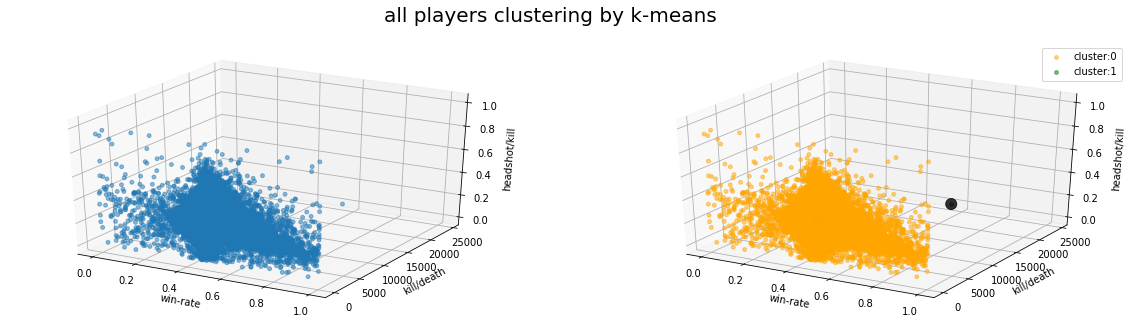

In [120]:
df_labeled, x_c, y_c, z_c = plot_n_cluster(2, df_drop)
# size of each cluster
print('cluster size distribution of {}'.format(target_rank))

count_label0 = list(df_labeled).count(0)
count_label1 = list(df_labeled).count(1)
# count_label2 = list(df_labeled).count(2)
# count_label3 = list(df_labeled).count(3)
# count_label4 = list(df_labeled).count(4)
# count_label5 = list(df_labeled).count(5)


print('cluster:\tsize:\t')
print('{}\t\t{}'.format(0, count_label0))
print('{}\t\t{}'.format(1, count_label1))
# print('{}\t\t{}'.format(2, count_label2))
# print('{}\t\t{}'.format(3, count_label3))
# print('{}\t\t{}'.format(4, count_label4))
# print('{}\t\t{}'.format(5, count_label5))

(74769, 15) (74770, 15)


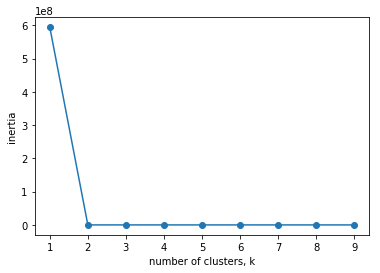

In [121]:
# analyze outlier and 
df_drop = df_clean.drop(df_clean.index[list(df_labeled).index(1)])
print(df_drop.shape, df_clean.shape)

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_drop[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

# analyze feature distribution

In [88]:
def analyze_feat_dist( data ):
    m = round(max(data), 1)
    avg = round(np.mean(data),1)
    skew = moment(data, 3)/(np.std(data))**3
    kurt = moment(data, 4)/(np.std(data))**4    
    return m,avg,skew,kurt

cluster 0:max = 9575.4	average=221.4	skew=8.3	kurt=225.4
cluster 1:max = 225.1	average=225.1	skew=nan	kurt=nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


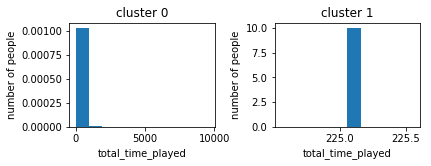

In [89]:
label_index_dict = {}
label_index_dict[0] = [i for i in range(len(df_labeled)) if df_labeled[i]==0]
label_index_dict[1] = [i for i in range(len(df_labeled)) if df_labeled[i]==1]
label_index_dict[2] = [i for i in range(len(df_labeled)) if df_labeled[i]==2]
label_index_dict[3] = [i for i in range(len(df_labeled)) if df_labeled[i]==3]

label_df_dict = {}
label_df_dict[0] = df_clean.iloc[label_index_dict[0]]
label_df_dict[1] = df_clean.iloc[label_index_dict[1]]
label_df_dict[2] = df_clean.iloc[label_index_dict[2]]
label_df_dict[3] = df_clean.iloc[label_index_dict[3]]

plt.figure()

def analyze_feature_of_cluster(cluster, feat):
    if feat == 'total_time_played':
        data = label_df_dict[cluster].total_time_played.values/3600
    
    elif feat == 'avg_kill_per_round':
        data = label_df_dict[cluster]['total_kills']/label_df_dict[cluster]['total_rounds_played']

    elif feat == 'headshot_per_round':
        data = label_df_dict[cluster]['total_kills_headshot']/label_df_dict[cluster]['total_rounds_played']
        
    elif feat == 'headshot-kill':
        data = label_df_dict[cluster]['headshot-kill']        
    
    m,avg,skew,kurt = analyze_feat_dist(data) 
    plt.hist(data, normed=True)
    plt.xlabel(feat)
    plt.ylabel('number of people')
    plt.title('cluster {}'.format(cluster))
    print('cluster {}:max = {}\taverage={}\tskew={}\tkurt={}'.format(cluster, m, avg, round(skew,1), round(kurt,1)))

plt.subplot(2,2,1)
feat = 'total_time_played'
analyze_feature_of_cluster(0,feat )

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()

cluster 0:max = 93.1	average=1.3	skew=25.1	kurt=1293.0
cluster 1:max = 122117.7	average=122117.7	skew=nan	kurt=nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


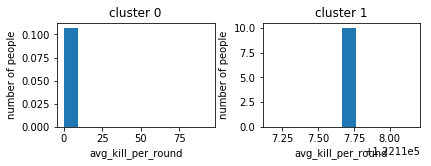

In [76]:
plt.figure()
plt.subplot(2,2,1)
feat = 'avg_kill_per_round'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()


cluster 0:max = 70.3	average=0.4	skew=62.7	kurt=5719.0
cluster 1:max = 0.3	average=0.3	skew=nan	kurt=nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


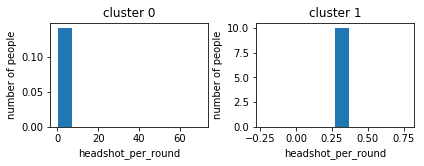

In [77]:
plt.figure()
plt.subplot(2,2,1)
feat = 'headshot_per_round'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))

plt.show()

cluster 0:max = 1.0	average=0.3	skew=1.1	kurt=8.7
cluster 1:max = 0.0	average=0.0	skew=nan	kurt=nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


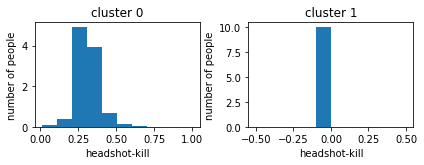

In [78]:
plt.figure()
plt.subplot(2,2,1)
feat = 'headshot-kill'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()